### Batch selection

#### This is the second step of the enrichment calculation

Batching experiments by overall similarity in intensity correlations. Background noise in experiments drift over a time, and batching by correlation allows more accurate significance testing.  

Recognizing batches is performed by calculating correlations between wildtype samples.
For some experiments that do not have wildtypes, WT is simulated by taking the median of all samples within the experiments

In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

script_path = Path.cwd().parent.parent.parent.parent / "script"
data_path = Path.cwd().parent.parent.parent.parent / "data"
sys.path.append(str(script_path))

from pyseus import basic_processing as ip
from pyseus import contrast_tools as ct

### Load the imputed IP table
The correct datestamp is required to find the input files

In [2]:
%store -r fig5_timestamp FIG5_USE_FROZEN
if FIG5_USE_FROZEN:
    raise Exception("USE_FROZEN is true, you probably want to skip enrichment and proceed from 3.aligned_umap")
timestamp = fig5_timestamp
print(f"Timestamp: {timestamp}")

maxQuant_csv = "proteinGroups.txt" 
# the above file is available through the PRIDE repository under the identifier PXD046440
# it is also available via the following FTP link: ftp://ftp.pride.ebi.ac.uk/pride/data/archive/2023/12/PXD046440/proteinGroups.txt

outprefix = f"{timestamp}_QC_filter_impute"

outdir = Path.cwd() / "output"
preprocessing_out = outdir / f"preprocessing"

Timestamp: 2024-10-27


In [3]:
# load bait imputed tables (IPs)
IP_path = preprocessing_out / f"{outprefix}_imputed_table.csv"

try:
    bait_imputed_table = pd.read_csv(IP_path, header=[0, 1], index_col=0)
except FileNotFoundError:
    print(f"File {IP_path} not found.\nPlease run 1.QC_filter_and_impute.ipynb first or specify the correct timestamp, current value is {timestamp}")
except pd.errors.ParserError:
    print(f"There was an error parsing the CSV file at {IP_path}.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

### Batch selection using the IP samples

In [4]:
medians = ip.median_replicates(bait_imputed_table, save_info=False)

# select WT cols to compute batches
wt_cols = [
    x for x in list(medians)
    if "WT" in x
    and "Harsh" not in x
    and "harsh" not in x
    and "arsenite" not in x
    and "brefeldin" not in x
]


ip11s = [x for x in list(medians) if "11-" in x]
ip11_median = medians[ip11s].median(axis=1)

# collection of all wildtypes (including simulated)
wildtypes = medians[wt_cols].copy()
# wildtypes['IP06-sim_WT'] = ip06_median.to_list()
wildtypes["IP11-sim_WT"] = ip11_median.to_list()

# sort cols
wt_sort = list(wildtypes)
wt_sort.sort()
wildtypes = wildtypes[wt_sort].copy()

In [5]:
# check WT columns
wildtypes

,09-WT,10-WT,12-WT,14-WT,17-WT,IP11-sim_WT
0,21.289100,21.977100,19.100011,21.834400,19.128136,18.606400
1,27.783500,27.918600,27.155800,25.977200,26.472100,25.851200
2,23.813400,23.504000,19.372200,24.704100,23.432500,24.494200
3,19.204941,18.631653,19.454873,19.575042,19.029845,18.867675
4,25.899000,26.034900,19.983492,25.221500,23.859000,27.893000
...,...,...,...,...,...,...
8587,19.003325,19.088391,18.779489,19.505257,17.803118,18.879035
8588,19.042772,18.978229,18.449595,22.491600,18.332016,20.663400
8589,18.881724,19.079488,19.321114,19.497953,19.032492,19.777481
8590,18.948762,18.370241,19.294439,19.905223,18.650819,19.068260


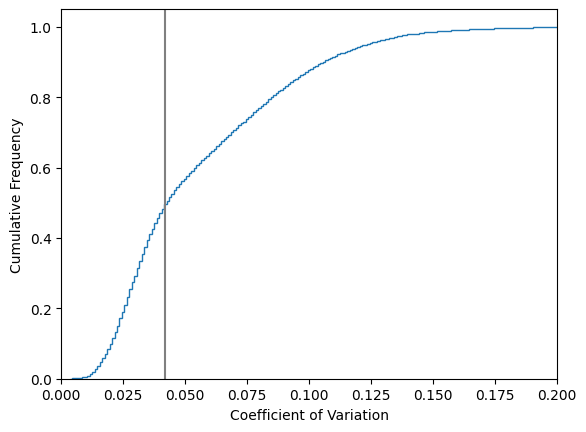

In [6]:
# to get a higher resolution of variance between wildtypes, remove proteins that do not change across WTs
# calculate the Coefficient of Variation for the filter.
stdevs = wildtypes.std(axis=1)
means = wildtypes.mean(axis=1)
coefs = stdevs / means

# plot distribution of Coefficients of Variation
fig = coefs.plot.hist(bins=300, histtype="step", cumulative=True, density=True)
fig.set_xlim([0, 0.2])
fig.axvline(x=0.042, color="grey")
fig.set_xlabel("Coefficient of Variation")
_ = fig.set_ylabel("Cumulative Frequency")

# threshold at 0.042 is just below 50% of all proteins
filtered = coefs[coefs >= 0.042]
filt_idx = filtered.index.to_list()
wildtype_filtered = wildtypes.loc[filt_idx].copy()

wildtype_filtered.shape

# add standard header
wildtype_final = ct.standard_pyseus_headers(wildtype_filtered)

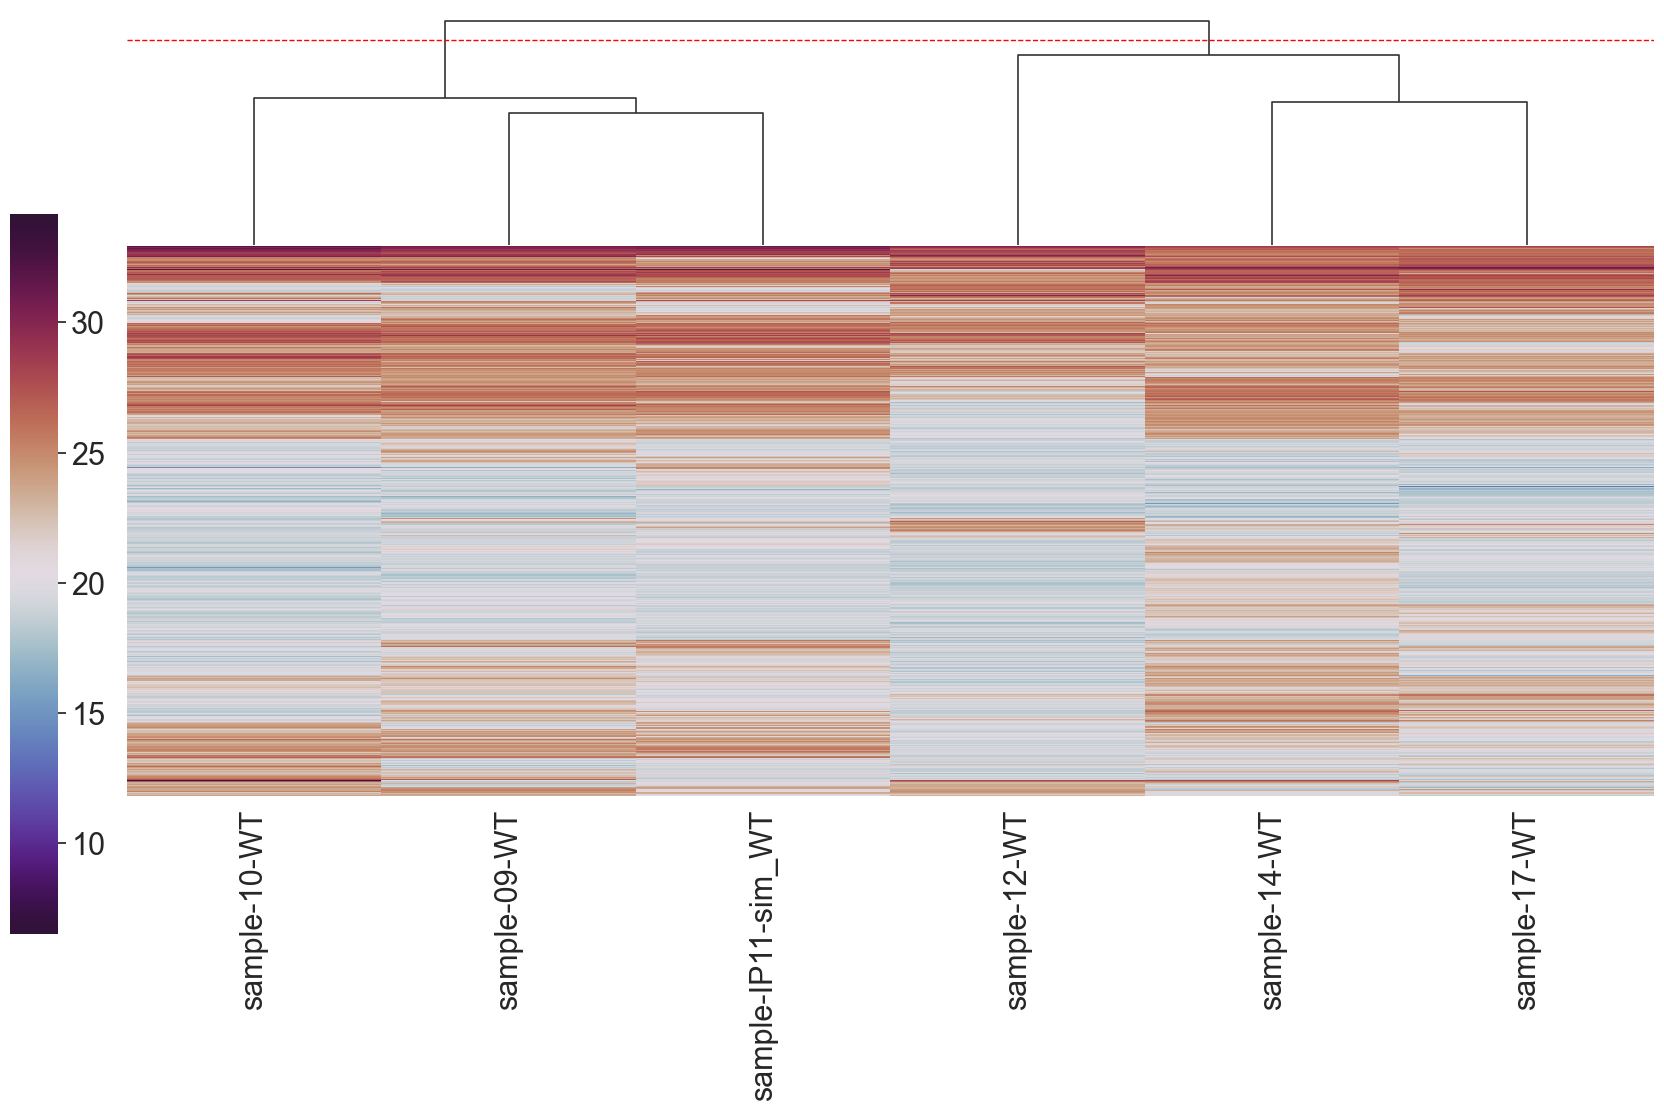

In [7]:
# clustermap to show the hierarchical clustering of the WTs (low_variance proteins removed)
sns.set(font_scale=2)
g = sns.clustermap(wildtype_final, cmap='twilight_shifted', figsize=(16,12), 
                   metric="euclidean", method="ward", 
                   dendrogram_ratio=(0,0.3), cbar_pos=(-0.05, 0.20, 0.03, 0.6), tree_kws=dict(linewidths=1.2),
                   yticklabels=False)
g.ax_heatmap.set_xlabel('')
g.ax_col_dendrogram.axhline(y=215, color='red', linewidth=1, linestyle='--')

plt.show()

In [8]:
batches = [["14", "12", "17"], ["09", "10", "11"]]